In [1]:
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from scipy.signal import butter, lfilter

In [3]:
csv_file = pd.read_csv('A001_signal.csv')

#### Loading first 10s for testing

In [4]:
data_0 = csv_file.loc[1:3600]

#### Calculate HR by using MLII

In [7]:
data = data_0['MLII']
ecg = data

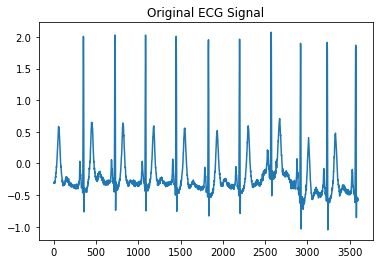

In [8]:
plt.title("Original ECG Signal")
plt.plot(data)

#### Putting a band pass filter

In [10]:
signal_freq = 360
nyquist_freq = 0.5 * 360
lowcut = 1
highcut = 15
low = lowcut / nyquist_freq
high = highcut / nyquist_freq
b,a = butter(1, [low, high], btype="band")
filtered_ecg = lfilter(b,a,data)

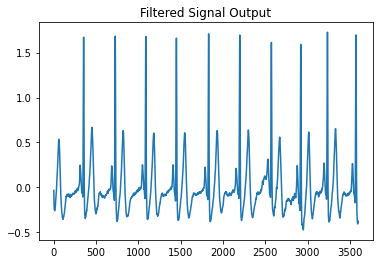

In [11]:
plt.title("Filtered Signal Output")
plt.plot(filtered_ecg)

#### Differentiating

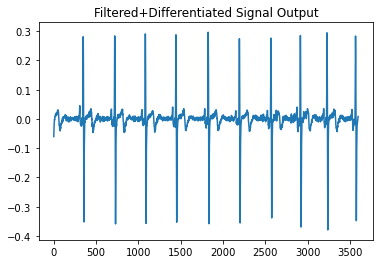

In [12]:
differentiated_ecg = np.ediff1d(filtered_ecg)
plt.title("Filtered+Differentiated Signal Output")
plt.plot(differentiated_ecg)

#### Sqaurring

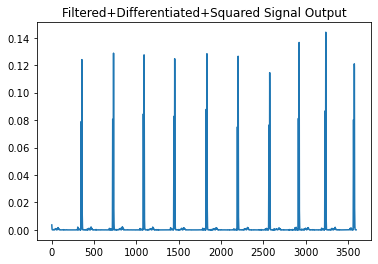

In [13]:
squarred_ecg = differentiated_ecg ** 2
plt.title("Filtered+Differentiated+Squared Signal Output")
plt.plot(squarred_ecg)

#### Moving window: convolution

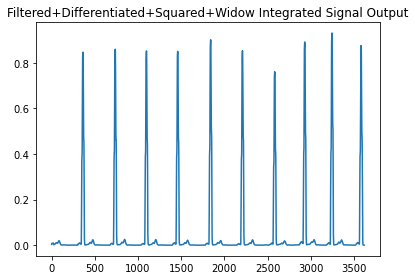

In [14]:
convolved_ecg = np.convolve(squarred_ecg, np.ones(21))
plt.title("Filtered+Differentiated+Squared+Widow Integrated Signal Output")
plt.plot(convolved_ecg)
plt.tight_layout()
plt.show()

#### Peak detection

In [15]:
data = convolved_ecg
len1 = data.size
spacing = 150

x = np.zeros(len1 + 2*spacing)
x[:spacing] = data[0] - 1.e-6
x[-spacing:] = data[-1] - 1.e-6
x[spacing: spacing+len1] = data
peak_candidate = np.zeros(len1)
peak_candidate[:] = True

for s in range(spacing):
            start = spacing - s - 1
            h_b = x[start: start + len1]  # before
            start = spacing
            h_c = x[start: start + len1]  # central
            start = spacing + s + 1
            h_a = x[start: start + len1]  # after
            peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

ind = np.argwhere(peak_candidate)
ind = ind.reshape(ind.size)

#### Threashold deciding

In [16]:
xn = (ecg - filtered_ecg)/(36*32)
x5 = convolved_ecg
peaki = convolved_ecg[0]
spki = 0
npki = 0
c=0
peak = [0]
threshold1 = spki
pk = []
for i in range(1,np.size(x5)-320):
    if x5[i]>peaki:
        peaki = x5[i]
                     
    npki = ((npki*(i-1))+xn[i])/i
    spki = ((spki*(i-1))+x5[i])/i
    spki = 0.875*spki + 0.125*peaki
    npki = 0.875*npki + 0.125*peaki
    
    threshold1 = npki + 0.25*(spki-npki)
    threshold2 = 0.5 * threshold1

    if(x5[i]>=threshold2):
        if(peak[-1]+24<i):
            peak.append(i)
            pk.append(x5[i])

In [20]:
ind = ind[data[ind] >( threshold2+threshold2)/2]
peak = ind

#### Get RR

In [23]:
diff=[]
for j in range(9):
    diff.append(peak[j]-peak[j+1])

#### Get timestamp for peak

In [24]:
peak = ind / 360

#### Get RR in sec

In [25]:
re_diff = np.asarray(diff)
re_diff = -1 * re_diff / 360

#### Get result for 3 sec to 9 sec
**There should consider 3 conditions:**
1. 1s has one peak - calculate normally
2. 1s has two peaks - add two HR together
3. 1s hasn't any peak - 60/RR

In [39]:
result = [0 for x in range(0,7)]
flag = 0
for i in range(2,10):
    if flag == 1:
        flag = 0
        continue
    if peak[i+1] < i+2 :
        result[i-2] = ((peak[i-1]-i)/re_diff[i-2] + (i+1-peak[i-1])/re_diff[i-1]) * 60
        i += 1
        result[i-3] += ((peak[i-1]-i)/re_diff[i-2] + (i+1-peak[i-1])/re_diff[i-1]) * 60
        flag = 1
    else:
        result[i-2] = ((peak[i-1]-i)/re_diff[i-2] + (i+1-peak[i-1])/re_diff[i-1]) * 60

In [40]:
result

[59.735582976580204,
 59.6767726236207,
 56.85822421368599,
 58.46756247860322,
 57.88217856312485,
 61.46141873044738,
 131.6722393726644]

In [41]:
result_fin = [[0 for x in range(2)] for y in range(7)]

In [42]:
for i in range(3,10):
    result_fin[i-3][0] = i
    result_fin[i-3][1] = result[i-3]

In [43]:
result_fin

[[3, 59.735582976580204],
 [4, 59.6767726236207],
 [5, 56.85822421368599],
 [6, 58.46756247860322],
 [7, 57.88217856312485],
 [8, 61.46141873044738],
 [9, 131.6722393726644]]

#### Futher steps:

0. Loading all the data (the result above only load first 10s)
1. Repeat the steps above for other signal like: VI
2. Calculate the average bpm for signals MLII and VI
3. Using average bpm as final result